In [ ]:
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from numpy import asarray
import PIL
import PIL.Image
from tqdm import tqdm

In [ ]:
import keras.backend as K
from tensorflow.keras import layers
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation,MaxPooling2D,concatenate,Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

In [ ]:
seed = 232
np.random.seed(seed)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_covid_path='/content/drive/MyDrive/PRML Course Project COVID-19 Using chest xray/Images/COVID/'
base_no_covid_path='/content/drive/MyDrive/PRML Course Project COVID-19 Using chest xray/Images/Non-COVID/'
base_path='/content/drive/MyDrive/PRML Course Project COVID-19 Using chest xray/Images/'

## Used separate dataset for training the model to create the masked images: [Dataset](https://www.kaggle.com/code/nikhilpandey360/lung-segmentation-from-chest-x-ray-dataset/data)

## U Net Model Setup

In [ ]:
train_gen = tf.keras.utils.image_dataset_from_directory(
      base_covid_path[:-6],
      validation_split=0.2,
      subset="training",
      seed=123,
      color_mode='grayscale',

      image_size=(224, 224),
      # batch_size=batch_size,
      )

Found 9535 files belonging to 2 classes.
Using 7628 files for training.


In [ ]:
test_gen = tf.keras.utils.image_dataset_from_directory(
      base_covid_path[:-6],
      validation_split=0.2,
      subset="validation",
      seed=123,
      color_mode='grayscale',

      image_size=(224, 224),
      # batch_size=batch_size,
      )

Found 9535 files belonging to 2 classes.
Using 1907 files for validation.


In [ ]:
def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [ ]:
model = unet((224,224,1))
model.load_weights("/content/drive/MyDrive/PRML Course Project COVID-19 Using chest xray/lung_segmentation.hdf5")

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 224, 224, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
model.compile(optimizer=Adam(lr=1e-5), loss="sparse_categorical_crossentropy",
                  metrics=[ 'binary_accuracy'])


## Saving .json and weights 

In [ ]:
# model.save("lungSegmentation.h5")

In [ ]:
# !pip install tensorflowjs
# !tensorflowjs_converter --input_format keras '/content/lungSegmentation.h5' '/content/lungSegmentation'

     |████████████████████████████████| 77 kB 5.0 MB/s 
     |████████████████████████████████| 462 kB 18.5 MB/s 


## Performing Image Segmentation

In [ ]:
def SegmentImage(model,path,img_shape = (224,224),threshold = 0.5):
    '''
    **********Input**************
    model: segmentation model (h5)
    path: filepath to image (string)
    img_shape: shape of the image(IMG_WIDTH,IMG_HEIGHT) used in segmenation model
    threshold: float value varing between 0 and 1, thresholding the mask
    *********Output*************
    return: Segment mask, segmented image, original image
    '''
    IMG_WIDTH,IMG_HEIGHT = img_shape
    ori_x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    ori_x = cv2.resize(ori_x, (IMG_HEIGHT,IMG_WIDTH))
    x = ori_x/255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=0)
    y_pred = model.predict(x)[0] > threshold
    y_pred = y_pred.astype(np.int32)
    plt.imsave('mask.jpeg',np.squeeze(y_pred),cmap='gray')
    maskapply = cv2.imread('mask.jpeg')
    maskapply = cv2.cvtColor(maskapply, cv2.COLOR_BGR2GRAY)
    chest_image = ori_x
    chest_image = cv2.resize(chest_image, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_NEAREST)
    masked_image = cv2.bitwise_and(maskapply,chest_image)
    # !cp 'mask'+str(i)+'.jpeg' "drive/MyDrive/PRML Course Project COVID-19 Using chest xray/Masked Images/"
    # files.download('mask'+str(i)+'.jpeg')
    return maskapply,masked_image,chest_image

In [ ]:
maskapply,masked_image,chest_image=SegmentImage(model,base_no_covid_path+'02.jpeg',) #Segmenting the image
maskapply_1,masked_image_1,chest_image_1=SegmentImage(model,base_covid_path+'02.jpeg',) #Segmenting the image

Text(0.5, 1.0, 'Masked Image after segmentation')

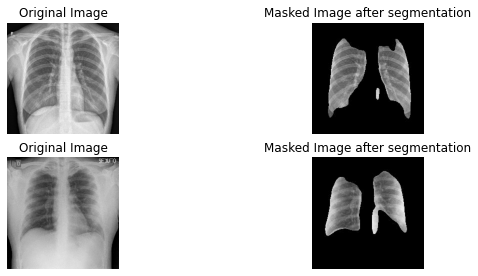

In [ ]:
rows = 3
columns = 2
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(rows, columns, 1)
plt.imshow(chest_image,cmap='gray')
plt.axis('off')
plt.title("Original Image")

fig.add_subplot(rows, columns, 2)
plt.imshow(masked_image,cmap='gray')
plt.axis('off')
plt.title("Masked Image after segmentation")

fig.add_subplot(rows, columns, 3)
plt.imshow(chest_image_1,cmap='gray')
plt.axis('off')
plt.title("Original Image")

fig.add_subplot(rows, columns, 4)
plt.imshow(masked_image_1,cmap='gray')
plt.axis('off')
plt.title("Masked Image after segmentation")


## Upload Masked Images to Drive

In [ ]:
import shutil
shutil.copy("/content/mask0.jpeg",'/content/drive/MyDrive/PRML Course Project COVID-19 Using chest xray/Masked Images/Non-COVID')

'/content/drive/MyDrive/PRML Course Project COVID-19 Using chest xray/Masked Images/Non-COVID/mask0.jpeg'

In [ ]:
from google.colab import files

In [ ]:
def SegmentImage(model,path,i,img_shape = (224,224),threshold = 0.5):
    '''
    **********Input**************
    model: segmentation model (h5)
    path: filepath to image (string)
    img_shape: shape of the image(IMG_WIDTH,IMG_HEIGHT) used in segmenation model
    threshold: float value varing between 0 and 1, thresholding the mask
    *********Output*************
    return: Segment mask, segmented image, original image
    '''
    IMG_WIDTH,IMG_HEIGHT = img_shape
    ori_x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    ori_x = cv2.resize(ori_x, (IMG_HEIGHT,IMG_WIDTH))
    x = ori_x/255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=0)
    y_pred = model.predict(x)[0] > threshold
    y_pred = y_pred.astype(np.int32)
    plt.imsave('mask'+str(i)+'.jpeg',np.squeeze(y_pred),cmap='gray')
    maskapply = cv2.imread('mask'+str(i)+'.jpeg')
    maskapply = cv2.cvtColor(maskapply, cv2.COLOR_BGR2GRAY)
    chest_image = ori_x
    chest_image = cv2.resize(chest_image, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_NEAREST)
    masked_image = cv2.bitwise_and(maskapply,chest_image)
    
    plt.imsave('mask'+str(i)+'.jpeg',(masked_image),cmap='gray')
    import shutil
    shutil.copy("/content/"+'mask'+str(i)+'.jpeg','/content/drive/MyDrive/PRML Course Project COVID-19 Using chest xray/Masked Images/COVID') #path where to upload the images, Must be changed before running loops.
    # !cp 'mask'+str(i)+'.jpeg' "drive/MyDrive/PRML Course Project COVID-19 Using chest xray/Masked Images/"
    # files.download('mask'+str(i)+'.jpeg')
    # return maskapply,masked_image,chest_image

In [ ]:
# maskapply,masked_image,chest_image=SegmentImage(model,base_no_covid_path+images[0],0)


In [ ]:
images = (list(os.listdir(base_no_covid_path)))

In [ ]:
for i in tqdm(range(len(images))):
  SegmentImage(model,base_no_covid_path+images[i],i)

100%|██████████| 5499/5499 [44:40<00:00,  2.05it/s]


In [ ]:
images = (list(os.listdir(base_covid_path)))
for i in tqdm(range(len(images))):
  SegmentImage(model,base_covid_path+images[i],i)

100%|██████████| 4043/4043 [33:10<00:00,  2.03it/s]
